### Temperature Predictions based on pyTorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
features = pd.read_csv('temps.csv')

# visulize the data
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


year/month/day/week indicates concrete time

temp_2: highest temp the day before yesterday

temp_1: highest temp yesterday

average: average highest temperature

actual: label value, actual highest temperature

In [3]:
print('data dimension:',features.shape)

data dimension: (348, 9)


In [4]:
# process time data
import datetime

years = features['year']
months = features['month']
days = features['day']

In [5]:
# date time format
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

In [6]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

In [7]:
plt.style.use('fivethirtyeight')

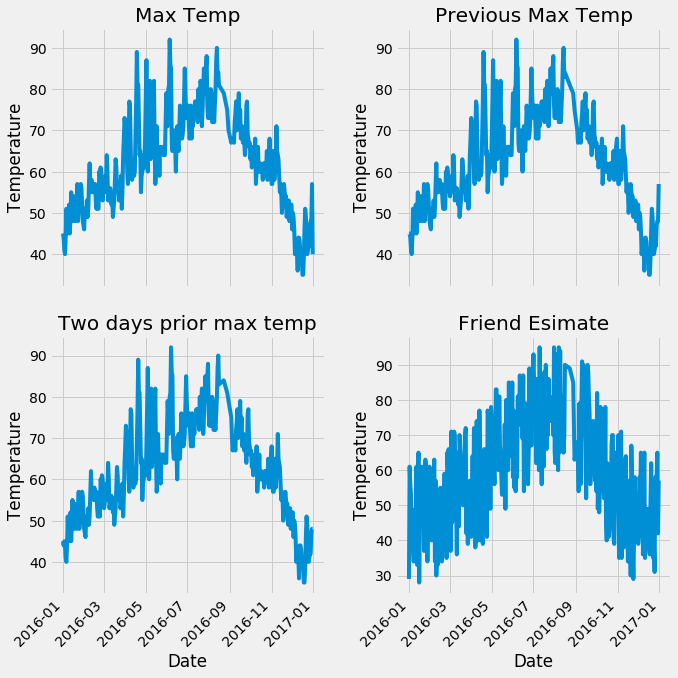

In [8]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
fig.autofmt_xdate(rotation=45)

# label value
ax1.plot(dates,features['actual'])
ax1.set_xlabel('');ax1.set_ylabel('Temperature');ax1.set_title('Max Temp')

#yesterday
ax2.plot(dates,features['temp_1'])
ax2.set_xlabel('');ax2.set_ylabel('Temperature');ax2.set_title('Previous Max Temp')

# the day before yesterday
ax3.plot(dates,features['temp_2'])
ax3.set_xlabel('Date');ax3.set_ylabel('Temperature');ax3.set_title('Two days prior max temp')

ax4.plot(dates,features['friend'])
ax4.set_xlabel('Date');ax4.set_ylabel('Temperature');ax4.set_title('Friend Esimate')

plt.tight_layout(pad=2)

In [9]:
# ont-hot encoding
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [10]:
# labels
labels = np.array(features['actual'])

# drop label in features
features = features.drop('actual',axis=1)

# save feature
feature_list = list(features.columns)

# transform into appropriate format
features = np.array(features)

In [11]:
features.shape

(348, 14)

In [12]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [13]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

##### Construct network model

In [14]:
x = torch.tensor(input_features,dtype = torch.float)
y = torch.tensor(labels,dtype = torch.float)

In [15]:
weights = torch.randn((14,128),dtype = torch.float, requires_grad = True)
biases = torch.randn(128,dtype = torch.float, requires_grad = True)
weights2 = torch.randn((128,1),dtype = torch.float,requires_grad = True)
biases2 = torch.randn(1,dtype = torch.float,requires_grad = True)

In [16]:
learning_rate = 0.001
losses = []

for i in range(1000):
    # hidden layer
    hidden = x.mm(weights) + biases
    
    # activation function
    hidden = torch.relu(hidden)
    
    # predictions
    predictions = hidden.mm(weights2) + biases2
    
    # calculate loss function
    loss = torch.mean((predictions - y) ** 2)
    losses.append(loss.data.numpy())
    
    # calculate loss function
    if i % 100 == 0:
        print('loss:',loss)
        
    # backward calculation
    loss.backward()
    
    # renew parameters
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    # Finally we should get the value to zero
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss: tensor(2088.8511, grad_fn=<MeanBackward1>)
loss: tensor(154.8393, grad_fn=<MeanBackward1>)
loss: tensor(146.0827, grad_fn=<MeanBackward1>)
loss: tensor(143.7528, grad_fn=<MeanBackward1>)
loss: tensor(142.6429, grad_fn=<MeanBackward1>)
loss: tensor(141.9559, grad_fn=<MeanBackward1>)
loss: tensor(141.4765, grad_fn=<MeanBackward1>)
loss: tensor(141.1084, grad_fn=<MeanBackward1>)
loss: tensor(140.8201, grad_fn=<MeanBackward1>)
loss: tensor(140.5871, grad_fn=<MeanBackward1>)


In [17]:
predictions.shape

torch.Size([348, 1])

#### A simpler neural network to construct 

In [18]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size)
)
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(),lr = 0.001)

In [19]:
## training neural network
losses = []
for i in range(1000):
    batch_loss = []
    
    # Use MINI-Batch method to train
    for start in range(0,len(input_features),batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],dtype = torch.float,requires_grad = True)
        yy = torch.tensor(labels[start:end],dtype = torch.float,requires_grad = True)
        predictions = my_nn(xx)
        loss = cost(predictions,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    # print loss
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

0 4014.951
100 37.73427
200 35.622128
300 35.272312
400 35.100082
500 34.964447
600 34.84515
700 34.729534
800 34.612354
900 34.490147


In [37]:
x = torch.tensor(input_features,dtype = torch.float)
predict = my_nn(x).data.numpy()

In [38]:
# transform date format
dates = [str(int(year)) + '-' + str(int(month)) + '-'+ str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

# create a table to save date and corresponding label value
true_date = pd.DataFrame(data = {'date':dates,'actual':labels})
true_date.head()

,actual,date
0,45,2016-01-01
1,44,2016-01-02
2,41,2016-01-03
3,40,2016-01-04
4,44,2016-01-05


In [39]:
feature_list

['year',
 'month',
 'day',
 'temp_2',
 'temp_1',
 'average',
 'friend',
 'week_Fri',
 'week_Mon',
 'week_Sat',
 'week_Sun',
 'week_Thurs',
 'week_Tues',
 'week_Wed']

In [40]:
### We can also create another one to save date and its model prediction
# months = features[:,feature_list.index('month')]
months = features[:,feature_list.index('month')]
days = features[:,feature_list.index('day')]
years = features[:,feature_list.index('year')]

In [42]:
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years,months,days)]

test_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date':test_dates,'prediction':predict.reshape(-1)})

In [43]:
predictions_data.head()

,date,prediction
0,2016-01-01,47.352928
1,2016-01-02,47.590385
2,2016-01-03,47.159988
3,2016-01-04,47.041386
4,2016-01-05,47.419556


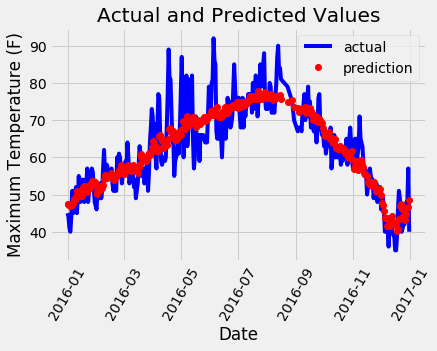

In [45]:
# True value
plt.plot(true_date['date'],true_date['actual'],'b-',label = 'actual')

# Prediction value
plt.plot(predictions_data['date'],predictions_data['prediction'],'ro',label = 'prediction')
plt.xticks(rotation = '60')
plt.legend()

# Name of picture
plt.xlabel('Date');
plt.ylabel('Maximum Temperature (F)');
plt.title('Actual and Predicted Values');